<a href="https://colab.research.google.com/github/PPatrickGU/ROB313/blob/main/3D1_tutorial_ROB313_2020_GU_DAJING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Computer Vision


In this laboratory work, we will estimate 2D homographies  using DLT.
 For this you will have to implement it. Then we will consider a case with outlier and you will have to implement a RANSAC code.
If you have never used jupyter notebooks, nor Colab notebooks, here is a short intro.


THIS NOTEBOOK BELONGS TO **GU - Dajing**

At the end of the session please send to gianni.franchi@ensta-paris.fr the link to your google drive.

## Homographies
In this first part, we will take an image of a plane distorted by a homography try to estimate it.



Fist we import all the libraries

In [726]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
from PIL import Image
from scipy import ndimage
from matplotlib import pyplot as plt
import random
from sklearn import linear_model, datasets
from google.colab import drive
from google.colab.patches import cv2_imshow


You can download the images from : https://perso.ensta-paris.fr/~manzaner/Cours/ROB313/TP_Homographies_images/

Please put it in your google drive

In [727]:
# First let us mount you google drive
drive.mount('/drive')


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Dimension de l'image : 333 lignes x 500 colonnes


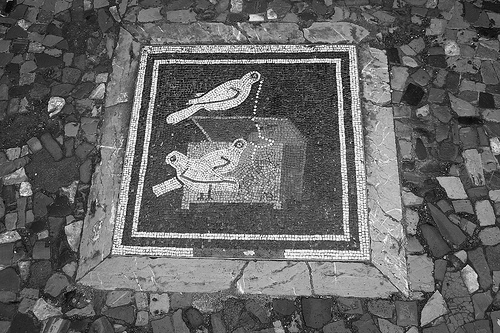

ok


In [728]:
# Let us read the image
PATH_IMG = '/drive/My Drive/Colab Notebooks/images'

im_col = cv2.imread(PATH_IMG+"/Pompei.jpg")
im = cv2.cvtColor(im_col, cv2.COLOR_BGR2GRAY)
#im_pil
(h,w) = im.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")
# let us plot the image
cv2_imshow(im)
print("ok")


this is the homography we want to estimate [[ 1.37054309e+00  3.26472981e-01 -9.09781842e+01]
 [ 3.46896567e-03  1.65383589e+00 -7.78613246e+01]
 [ 1.73448284e-04  1.14069045e-03  1.00000000e+00]]


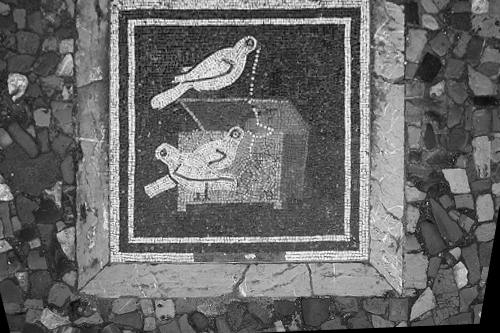

In [729]:
# Let us apply a homography on the image
H_true = np.array([[ 1.37054309e+00 , 3.26472981e-01 ,-9.09781842e+01],
 [ 3.46896567e-03,  1.65383589e+00, -7.78613246e+01],
 [ 1.73448284e-04,  1.14069045e-03 , 1.00000000e+00]])
print('this is the homography we want to estimate', H_true)

im2 = cv2.warpPerspective(im, H_true, (w,h))

#Image.fromarray(im2_pil)
cv2_imshow(im2)

## Homography Transformations

**Q/ How many degrees of freedom is present on your Homography?**

-> There are 8 degrees of freedom (2 for scale, 2 for rotation, 2 for translation and 2 for line at infinity)

**Q/ How many points do you need?**

-> Every point can help us to fix two degrees of freedoms so at least 4 points are needed.



**Q/ complete the DLTcalib2 and Normalization code**

In [730]:
def Normalization(x, height, width):
    '''
    Normalization of coordinatesbased on the slide 60 of the course
    Input
    -----
    x: the data to be normalized (directions at different columns and points at rows)
    height: the height of the input image
    width: the width of the input image

    Output
    ------
    Tr: the transformation matrix (translation plus scaling)
    x: the transformed data
    '''
    Tr = np.array([[2/width, 0, -1], 
            [0,  2/height, -1], 
            [0, 0, 1]])
    x = np.matmul(Tr, x.T).T
    return Tr, x

In [731]:
def distance_carre(X, x):
    distance = 0
    rows, cols = X.shape
    for i in range(rows):
      distance += (X[i][0]-x[i][0])**2 + (X[i][1]-x[i][1])**2 + (X[i][2]-x[i][2])**2
    # distance = distance**0.5
    return distance

In [732]:
def DLTcalib2_Normalize(xyz, uv, height, width):
    '''
    Camera calibration by DLT using known object points and their image points.
    Input
    -----
    height: the height of the input image
    width: the width of the input image
    xyz: coordinates in the object 2D space.
    uv: coordinates in the image 2D space.
    The coordinates (x,y,z and u,v) are given as columns and the different points as rows.
    There must be at least 4 calibration points for the 2D DLT.
    Output
    ------
     H: array of 9 parameters of the calibration matrix.
     err: error of the DLT (mean residual of the DLT transformation in units of camera coordinates).
    '''

    # normalization of the input data
    Tr, xyz_n = Normalization(xyz, height, width)
    Tr, uv_n = Normalization(uv, height, width)

    # DLT algorithm
    N = xyz_n.shape[0] # 5 here
    n = xyz_n.shape[1] # 3 here
    
    M  = np.empty(shape=[2*N, n*n]) # (10,9) here

    M_up = np.column_stack((xyz_n, np.zeros((N,3)), -xyz_n[:,0]*uv_n[:,0], -xyz_n[:,1]*uv_n[:,0], -uv_n[:,0]))  
    M_below = np.column_stack((np.zeros((N,3)), xyz_n, -xyz_n[:,0]*uv_n[:,1], -xyz_n[:,1]*uv_n[:,1], -uv_n[:,1]))
    M = np.vstack((M_up,M_below))

    U, S, V = np.linalg.svd(M)
    h = V[-1]
    h = h/h[-1]
    H = h.reshape(n ,n)
    
    # Denomalization of homography
    H = np.matmul(np.linalg.inv(Tr), np.matmul(H, Tr))

    #err = np.sum(np.square((uv.T - np.matmul(H, xyz.T))) + np.square((xyz.T - np.matmul(np.linalg.pinv(H), uv.T)))) 
    err = (distance_carre(uv, (np.matmul(H, xyz.T)).T) + distance_carre(xyz, (np.matmul(np.linalg.pinv(H), uv.T)).T)) / N
    # err = (distance_carre(uv, (np.matmul(H, xyz.T)).T) ) / N
    return H, err

In [733]:
def DLTcalib2(xyz, uv):
    '''
    Camera calibration by DLT using known object points and their image points.
    Input
    -----

    xyz: coordinates in the object 2D space.
    uv: coordinates in the image 2D space.
    The coordinates (x,y,z and u,v) are given as columns and the different points as rows.
    There must be at least 4 calibration points for the 2D DLT.
    Output
    ------
     H: array of 9 parameters of the calibration matrix.
     err: error of the DLT (mean residual of the DLT transformation in units of camera coordinates).
    '''

    # DLT algorithm
    N = xyz.shape[0] # 5 here
    n = xyz.shape[1] # 3 here

    
    M  = np.empty(shape=[2*N, n*n]) # (10,9) here

    M_up = np.column_stack((xyz, np.zeros((N,3)), -xyz[:,0]*uv[:,0], -xyz[:,1]*uv[:,0], -uv[:,0]))  
    M_below = np.column_stack((np.zeros((N,3)), xyz, -xyz[:,0]*uv[:,1], -xyz[:,1]*uv[:,1], -uv[:,1]))
    M = np.vstack((M_up,M_below))

    U, S, V = np.linalg.svd(M)
    h = V[-1]
    h = h/h[-1]
    H = h.reshape(n ,n)
    
    # err = np.sum(np.square((uv.T - np.matmul(H, xyz.T))) + np.square((xyz.T - np.matmul(np.linalg.pinv(H), uv.T)))) # geometric distance
    err = (distance_carre(uv, (np.matmul(H, xyz.T)).T) + distance_carre(xyz, (np.matmul(np.linalg.inv(H), uv.T)).T)) / N
    # err = (distance_carre(uv, (np.matmul(H, xyz.T)).T) ) / N
    return H, err

In [734]:
# build a set of points
X_1=np.array([[100,440,1]])
X_2=np.array([[200,30,1]])
X_3=np.array([[20,80,1]])
X_4=np.array([[40,200,1]])
X_5=np.array([[300,140,1]])

X=np.concatenate((X_1, X_2, X_3, X_4, X_5), axis=0)

X=np.concatenate((X_1, X_2, X_3, X_4, X_5), axis=0)
np.random.seed(0)
x=np.transpose(np.matmul(H_true, np.transpose(X)))+ np.random.normal(0, 0.5, size=(5, 3))
# x=np.transpose(np.matmul(H_true, np.transpose(X)))
x[:,2]=1

print('initial point',X) # let us print the initial points
print('transformed point',x) # let us transform points

initial point [[100 440   1]
 [200  30   1]
 [ 20  80   1]
 [ 40 200   1]
 [300 140   1]]
transformed point [[190.60626261 650.37344217   1.        ]
 [194.04506983 -26.61867577   1.        ]
 [-36.97443971  54.43924731   1.        ]
 [ 29.34343485 253.11663381   1.        ]
 [366.271479   154.77722721   1.        ]]


In [735]:
# Let us apply the DLT code to estimate the Homography
L_N, err_N = DLTcalib2_Normalize(X, x, im.shape[0], im.shape[1])
L, err = DLTcalib2(X, x)
print('estimated homography (Normalized DLT)',L_N)
print('estimated homography (DLT)',L)
print('estimated homography',np.rint(L)) #np.floor(L)) np.ceil(L)) 
print('Truth homography',H_true)
print('The error of you homography estimation is of',err)

estimated homography (Normalized DLT) [[ 1.37258459e+00  3.23692126e-01 -9.02624195e+01]
 [ 7.96936224e-03  1.64383505e+00 -7.75139123e+01]
 [ 2.73377481e-05 -6.45787462e-06  9.94240799e-01]]
estimated homography (DLT) [[ 1.38016684e+00  3.25422660e-01 -9.07523119e+01]
 [ 7.91553482e-03  1.65277113e+00 -7.79072176e+01]
 [ 2.68058067e-05 -7.12387369e-06  1.00000000e+00]]
estimated homography [[  1.   0. -91.]
 [  0.   2. -78.]
 [  0.  -0.   1.]]
Truth homography [[ 1.37054309e+00  3.26472981e-01 -9.09781842e+01]
 [ 3.46896567e-03  1.65383589e+00 -7.78613246e+01]
 [ 1.73448284e-04  1.14069045e-03  1.00000000e+00]]
The error of you homography estimation is of 3.1140994004130316


## Robust linear model estimation using RANSAC
**Q/ please have a look at the [Skylearn tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html) and try to understand it**


In [736]:
# Test on Skylearn tutorial

**Q/ please complete the RANSAC code** 



In [737]:
def random_partition(n, n_data1, n_data2):
    """return n random samples of n_data"""
    l, c = n_data1.shape
    idxs = list(range(l))
    np.random.seed(0)
    np.random.shuffle(idxs)

    samples1 = np.ones(shape = (n, c))
    samples2 = np.ones(shape = (n, c))
    for i in range(n):
      samples1[i] = n_data1[idxs[i],:]
      samples2[i] = n_data2[idxs[i],:]
    return samples1, samples2

In [738]:
 def run_ransac(xyz, uv, threshold, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
    """ RANSAC Coder for finding homography fit
    Input
    -----
    xyz: coordinates in the object 2D space.
    uv: coordinates in the image 2D space.
    threshold :  is the threshold to say if a data is inlier or not after reconstruction
    sample_size : is the size of the sample use to calculate the DLT
    goal_inliers : is the number of inlier on the dataset
    max_iterations : maximum number of iteration
    stop_at_goal : allow early stop
    random_seed : a seed to controle the process

    Output
    ------
     best_model: array of 11 parameters of the calibration matrix.
     best_ic: best consensus value.
     err: error of the DLT (mean residual of the DLT transformation in units of camera coordinates).
     """

    n = xyz.shape[1]
    best_model = np.zeros(shape=(n,n))
    iterations = 0
    X_inliers_max = []
    x_inliers_max = []

    while iterations < max_iterations: 

      X_samples, x_samples = random_partition(sample_size, xyz, uv) 

      H, err = DLTcalib2(X_samples, x_samples)

      X_inliers = []
      x_inliers = []

      for i in range(xyz.shape[0]):
        a, b = xyz[i, :], uv[i, :]

        err = np.sum(np.square(b - np.matmul(H, a.T).T))**0.5

        # print(err)  
        if err <= threshold:
          X_inliers.append(a.tolist())
          x_inliers.append(b.tolist()) 

      if len(X_inliers) > len(X_inliers_max) and len(X_inliers) >= goal_inliers:
        X_inliers_max = X_inliers
        x_inliers_max = x_inliers
        
      iterations += 1

    best_ic = len(X_inliers_max) 
    best_model, err = DLTcalib2(np.asarray(X_inliers_max), np.asarray(x_inliers_max))
    # print(2)

    return best_model, best_ic, err

**Q/ please write a code to generate  1000 points  with 100 outliers and test your ransac code and compare it to the DLT**

In [739]:
# we use the function make_regression to generate a random regression problem. 
n_samples = 1000
n_outliers = 100

# we call X and x the name of the points such that x=HX
X_inliers = np.ones(shape=(n_samples,3))
X_outliers = np.ones(shape=(n_outliers,3))
x_inliers = np.ones(shape=(n_samples,3))
x_outliers = np.ones(shape=(n_outliers,3))

X0, X1, coef = datasets.make_regression(n_samples = n_samples, n_features=1, n_informative=1, noise = 10, coef=True, random_state=1)


X_inliers[:,0] = X0.T
X_inliers[:,1] = X1.T

x_inliers = np.transpose(np.matmul(H_true, np.transpose(X_inliers))) + np.random.normal(0, 0.5, size=(n_samples, 3))
# x_inliers = np.transpose(np.matmul(H_true, np.transpose(X_inliers)))

# Add outlier data
np.random.seed(0)
X_outliers = 3 + 5* np.random.normal(size=(n_outliers, 3))
x_outliers = -3 + 10 * np.random.normal(size=(n_outliers, 3))
X = np.concatenate((X_inliers, X_outliers), axis=0)
x = np.concatenate((x_inliers, x_outliers), axis=0)



In [740]:
# best_model, best_ic, err = run_ransac(X, x, 5500, 10, 800, 100)  #(X, x, 5.0, 10, 800, 10)
best_model, best_ic, err = run_ransac(X, x, 20, 10, 800, 1000)  #(X, x, 5.0, 10, 800, 10)
print('estimated homography',best_model) #np.floor(L)) np.ceil(L)) 
print('estimated homography',np.rint(best_model))
print('Truth homography',H_true)
print('err(geomtric distance) =',err)
print('best_ic =', best_ic)

estimated homography [[ 4.63123305e+00  2.45217974e-01 -9.09854554e+01]
 [ 2.94481337e+00  1.57968483e+00 -7.78598456e+01]
 [-2.85832072e-02  7.12756921e-04  1.00000000e+00]]
estimated homography [[  5.   0. -91.]
 [  3.   2. -78.]
 [ -0.   0.   1.]]
Truth homography [[ 1.37054309e+00  3.26472981e-01 -9.09781842e+01]
 [ 3.46896567e-03  1.65383589e+00 -7.78613246e+01]
 [ 1.73448284e-04  1.14069045e-03  1.00000000e+00]]
err(geomtric distance) = 1816.8720329281787
best_ic = 945


In [741]:
# L, err = DLTcalib2(X[0:n_samples-1], x[0:n_samples-1])
L, err = DLTcalib2(X, x)
print('estimated homography',L)
print('estimated homography',np.rint(L)) #np.floor(L)) np.ceil(L)) 
print('Truth homography',H_true)
print('err =',err)

estimated homography [[ 7.33990834e+01 -1.40646493e+00 -8.80693100e+01]
 [ 7.35903875e+01 -1.45741193e-01 -8.26907521e+01]
 [-1.53316924e+00  3.69306106e-02  1.00000000e+00]]
estimated homography [[ 73.  -1. -88.]
 [ 74.  -0. -83.]
 [ -2.   0.   1.]]
Truth homography [[ 1.37054309e+00  3.26472981e-01 -9.09781842e+01]
 [ 3.46896567e-03  1.65383589e+00 -7.78613246e+01]
 [ 1.73448284e-04  1.14069045e-03  1.00000000e+00]]
err = 52839.1266537897
